# Food vision / identification 🍕🍣🥩

In [44]:
'''

# For this notebook to run with updated APIs, torch 1.12+ and torchvision 0.13+ should be satisfied
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
    
'''

'\n\n# For this notebook to run with updated APIs, torch 1.12+ and torchvision 0.13+ should be satisfied\ntry:\n    import torch\n    import torchvision\n    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"\n    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"\n    print(f"torch version: {torch.__version__}")\n    print(f"torchvision version: {torchvision.__version__}")\nexcept:\n    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")\n    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113\n    import torch\n    import torchvision\n    print(f"torch version: {torch.__version__}")\n    print(f"torchvision version: {torchvision.__version__}")\n    \n'

In [45]:
'''

# regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    # Clones github repo
    # moves specified directory to root with '.'
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/aayush2058/pytorch_fundamentals
    !move pytorch_fundamentals/going_modular .
    
'''

'\n\n# regular imports\nimport matplotlib.pyplot as plt\nimport torch\nimport torchvision\n\nfrom torch import nn\nfrom torchvision import transforms\n\n# Try to get torchinfo, install it if it doesn\'t work\ntry:\n    from torchinfo import summary\nexcept:\n    print("[INFO] Couldn\'t find torchinfo... installing it.")\n    !pip install -q torchinfo\n    from torchinfo import summary\n\n# Try to import the going_modular directory, download it from GitHub if it doesn\'t work\ntry:\n    from going_modular import data_setup, engine\nexcept:\n    # Get the going_modular scripts\n    # Clones github repo\n    # moves specified directory to root with \'.\'\n    print("[INFO] Couldn\'t find going_modular scripts... downloading them from GitHub.")\n    !git clone https://github.com/aayush2058/pytorch_fundamentals\n    !move pytorch_fundamentals/going_modular .\n    \n'

In [46]:
import torch
import torchvision

In [47]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [48]:
!nvidia-smi

Wed Sep 13 12:03:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8               8W /  95W |   1552MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Get data

Using our pizza, steak, sushi data to build a transfer learning model on

In [49]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If data doesnot exist
if image_path.is_dir():
    print(f"{image_path} directory exists, skipping re-download.")
else:
    print(f"No {image_path}, downloading it...")
    image_path.mkdir(parents = True, exist_ok = True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/aayush2058/pytorch_fundamentals/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)
        
    # unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(image_path)
    
    # Remove .zip file
#     os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists, skipping re-download.


In [50]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### Datasets and DataLoaders
There are two ways to create transformer
1. **Manual transform** - Define transform ourself
2. **Automatic** - Defined by the used model

* Data should be passed the same way the model was trained

##### Creating a transform (manual)


In [51]:
from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                std = [0.229, 0.224, 0.225])

manual_transform = transforms.Compose([transforms.Resize(size = (224, 224)),
                                      transforms.ToTensor(), #gets image into range(0-1)
                                      normalize]) #make sure image have the same distribution as ImageNet pretrained model

In [52]:
# DataLoaders using manual transforms
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = manual_transform,
                                                                              batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f07a867fd0>,
 ['pizza', 'steak', 'sushi'])

##### Creating a transform (automatic)


In [53]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = the best available / performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [54]:
# Get the transforms used to create pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [55]:
# DataLoaders using automatic transforms
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = auto_transforms,
                                                                              batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1f07a871790>,
 ['pizza', 'steak', 'sushi'])

### Getting a pretrained model

There are various places to get a pretrained model, such as:

1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

#### Which model to use?

* Problem similar model

Things to consider:
1. Speed - how fast does it run?
2. Size - How big is the model? What size do we want? (smallest size possible)
3. Performance - How well does it solve our problem?

How?

**experiment, experiment, experiment**

In my case, I will be using EfficientNet_B0 from
[PyTorch official weights](https://pytorch.org/vision/stable/models.html)

In [56]:
# Setting up a instance of pretrained model
model = torchvision.models.efficientnet_b0(weights = weights)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [57]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [58]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [59]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

#### Getting a summary of the model with `torchinfo`

In [60]:
from torchinfo import summary

summary(model = model,
       input_size = (1, 3, 224, 224),
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

#### Freezing the base model and changing the output layer to suit our need
 
With a feature extractor model, typically we need to 'freeze' the base layers of pretrained/ foundation model and update the output layers to suit our own problem.

In [61]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

In [62]:
# After freezing the base layers (partial trainability) only the output layers are trainable
summary(model = model,
       input_size = (1, 3, 224, 224),
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [63]:
# Check the classifier head
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [64]:
# Update the classifier head of the model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
                                nn.Dropout(p = 0.2, inplace = True),
                                nn.Linear(in_features = 1280,
                                         out_features = len(class_names))).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [65]:
# After freezing the base layers (partial trainability) only the output layers are trainable
# After updating classifier

summary(model = model,
       input_size = (1, 3, 224, 224),
       col_names = ["input_size", "output_size", "num_params", "trainable"],
       col_width = 20,
       row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Fitting data into the model

In [66]:
# Define loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                            lr = 0.001)

In [67]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = 10,
                      device = device)

end_time = timer()

print(f"[INFO] Total time to train: {end_time - start_time}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8047 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5769 | train_acc: 0.8984 | test_loss: 0.5714 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5260 | train_acc: 0.9141 | test_loss: 0.5456 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5249 | train_acc: 0.8047 | test_loss: 0.5300 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5080 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8164 | test_loss: 0.4389 | test_acc: 0.9062
[INFO] Total time to train: 141.38890919997357


In [68]:
results

{'train_loss': [1.0929302051663399,
  0.8702579140663147,
  0.7647983282804489,
  0.7114287093281746,
  0.6252085119485855,
  0.5769450068473816,
  0.5259565263986588,
  0.5248978696763515,
  0.5667212903499603,
  0.4847172126173973],
 'train_acc': [0.40234375,
  0.77734375,
  0.8046875,
  0.7578125,
  0.79296875,
  0.8984375,
  0.9140625,
  0.8046875,
  0.8125,
  0.81640625],
 'test_loss': [0.9125136931737264,
  0.7900493741035461,
  0.7433322866757711,
  0.6343927383422852,
  0.6237542430559794,
  0.571378747622172,
  0.5456072290738424,
  0.5300234953562418,
  0.5079701840877533,
  0.4388969838619232],
 'test_acc': [0.5501893939393939,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8863636363636364,
  0.8759469696969697,
  0.8759469696969697,
  0.8768939393939394,
  0.8456439393939394,
  0.90625]}

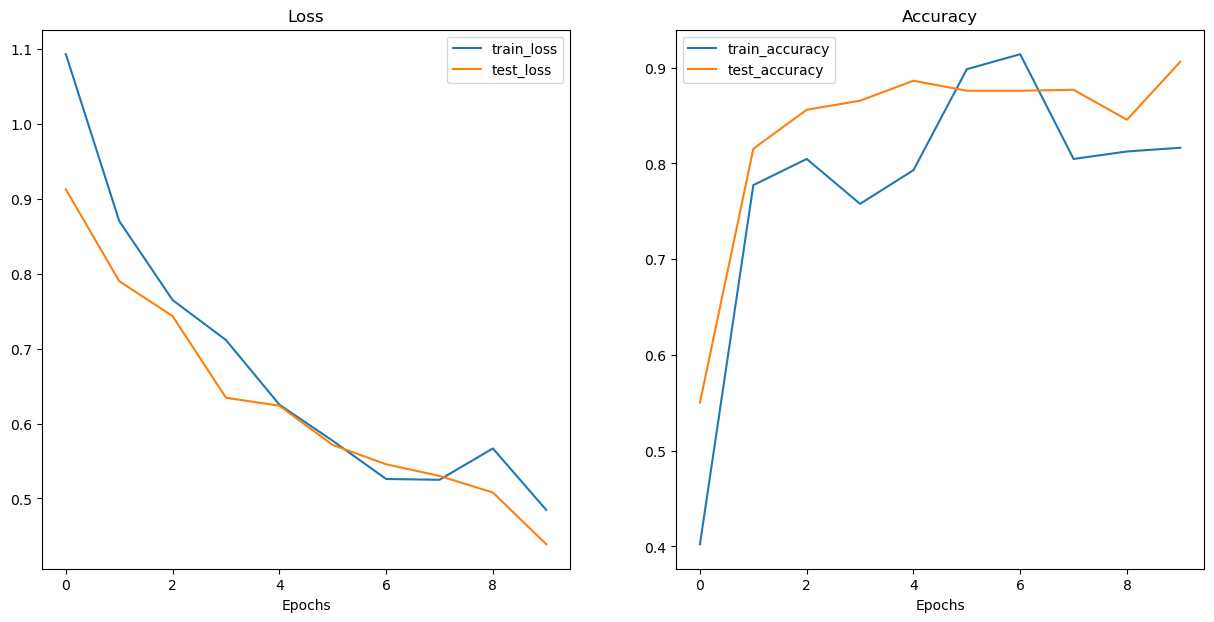

In [69]:
import requests
from pathlib import Path

try:
    from helper_functions import plot_loss_curves

    # if Path("helper_functions.py").is_file():
    #     print("helper_functions.py already exists, skipping download")
except:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/aayush2058/pytorch_fundamentals/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)
    print("Downlaod successfull....")
    
# Plot loss curves of above model
plot_loss_curves(results)

### Make predictions on images from the test set

Make sure:
1. Same shape - Images need to be in same shape as the model was trained on
2. Sane datatype - Custom data should be in same datatype
3. Same device
4. Same transform

To do all of this automatically, creating a function called `pred_and_plot_image()`
1. Take in a trained model, list of classes, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to the batch size)
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities labels using `torch.softmax`
9. Convert the model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.


In [70]:
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt


# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                       image_path: str,
                       class_names: List[str],
                       image_size: Tuple[int, int] = (224, 224),
                       transform: torchvision.transforms = None,
                       device: torch.device = device):
    
    # 2. Open the image with PIL
    img = Image.open(image_path)
    
    # 3. Create a transform if doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
                                            transforms.Resize(image_size),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                  std = [0.229, 0.224, 0.225])
                                            ])
        
    # Predict on image---------------------------
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on inference mode and eval mode
    model.eval()
    with torch.inference_mode():
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim = 0) #[B, C, H, W]
        
        # 7. Make a prediction on the transformed image by passing it to the model (also ensure it is on the target device)
        target_image_pred = model(transformed_image.to(device))
        
        # 8. Convert the model's output logits to pred probs
        target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
        
        # 9. Convert the model's pred probs to pred labels
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
        
        # 10. Plot image with predicted label and probability
        plt.figure()
        plt.imshow(img)
        plt.title(f"Pred: {class_names[target_image_pred_label]} | {target_image_pred_probs.max():.3f}")
        plt.axis(False);
    

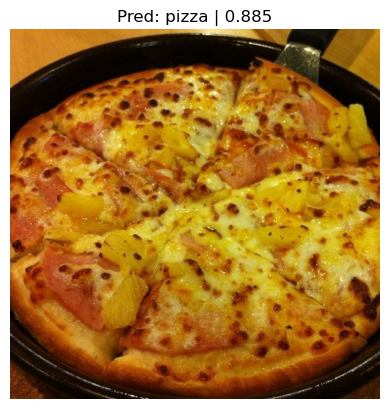

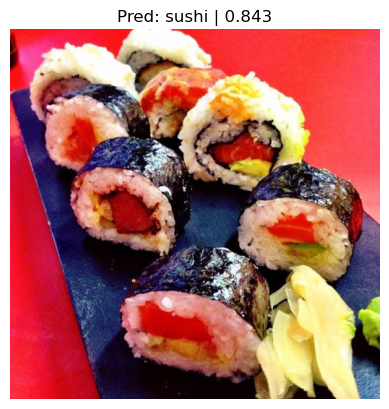

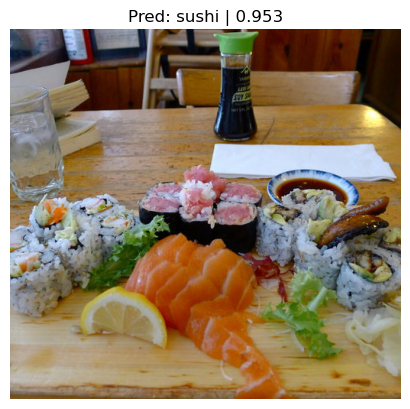

In [71]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population = test_image_path_list,
                                      k = num_images_to_plot)
test_image_path_sample

# Predictions and plot
for image_path in test_image_path_sample:
    pred_and_plot_image(model = model,
                       image_path = image_path,
                       class_names = class_names,
                       image_size = (224, 224),
                       device = device) 

### Saving model

In [72]:
from going_modular import utils

utils.save_full_model(model=model,
           target_dir="models",
           model_name="01_Efficeint_Net_B0_food_identification.pth")

[INFO] Saving model to: models\01_Efficeint_Net_B0_food_identification.pth


### Loading saved model

In [75]:
loaded_model = torch.load("models/01_Efficeint_Net_B0_food_identification.pth")
loaded_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Prediction on custom image

In [73]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path/"square_pizza.jpg"

# Download the image if it doesn't exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://github.com/aayush2058/pytorch_fundamentals/raw/main/data/square_pizza.jpg")
        print(f"Downloading {custom_image_path}.... ")
        f.write(request.content)
        print("successful")      
else:
    print(f"{custom_image_path} already exists, skipping download...")

data\square_pizza.jpg already exists, skipping download...


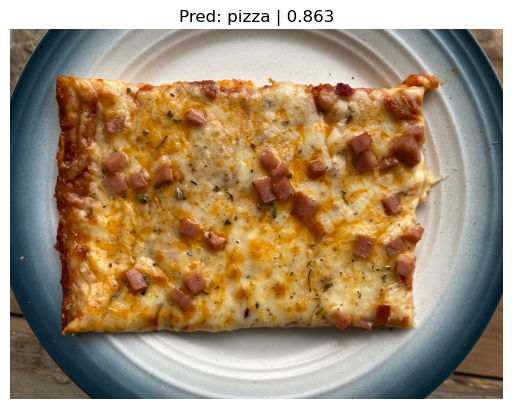

In [77]:
# Prediction
pred_and_plot_image(model = loaded_model,
                   image_path = custom_image_path,
                   class_names = class_names)